## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
# important libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pickle 
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks_cwt

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

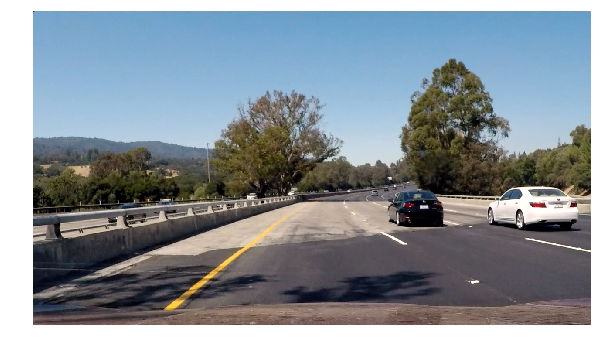

In [2]:
#reading in an image
image = mpimg.imread('test_images/test4.jpg')
#image = mpimg.imread('test_images/solidWhiteRight.jpg')

plt.figure(figsize=(10,10))
plt.imshow(image);  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
plt.axis('off');

In [3]:
#Functions for camera calibration:

#Undistort image by using camera calibration
def cal_undistort(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

## First, I'll compute the camera calibration using chessboard images

In [4]:
#Camera Calibration

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners   ... personalize
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

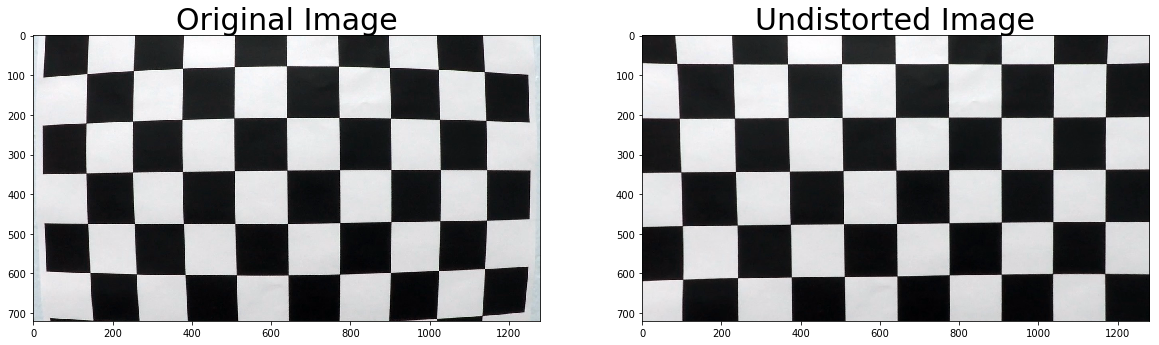

In [5]:
#Test Camera Calibration

%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/test_image.jpg')

img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Image Preprocessing...

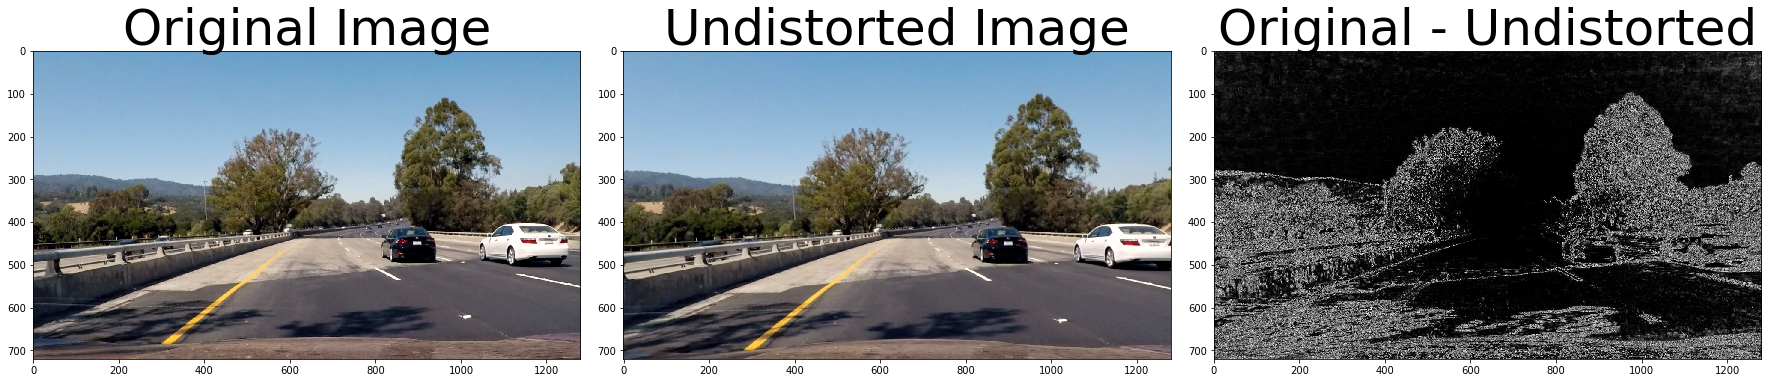

In [6]:
#Undistort image
img = mpimg.imread('test_images/test4.jpg')    #Read in a test image
#gaussian_blur = gaussian_blur(img)
undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
ax3.imshow(np.sum((img-undistorted)**2,axis=2),cmap='gray')
ax3.set_title('Original - Undistorted', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [115]:
#Functions for pre-processing:

#Gaussian_blur
def gaussian_blur(img, kernel_size = 5):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

#Undistort image by using camera calibration
def cal_undistort(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

#Estimate source and destination points ....  personalize
def get_perspective_src_dst(img):
    img_size = img.shape
    ht_window = np.uint(img_size[0]/1.5)
    hb_window = np.uint(img_size[0])
    c_window = np.uint(img_size[1]/2)
    ctl_window = c_window - .2*np.uint(img_size[1]/2)
    ctr_window = c_window + .2*np.uint(img_size[1]/2)
    cbl_window = c_window - 1*np.uint(img_size[1]/2)
    cbr_window = c_window + 1*np.uint(img_size[1]/2)
    src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],[ctr_window,ht_window],[ctl_window,ht_window]])
    dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],[img_size[1],0],[0,0]])
    
    return src, dst

#Apply opencv perspective transform
def warp_image(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

#Color and Gradient Threshold
def Gradient_Threshold(L, S):
    # Sobel x
    sobelx = cv2.Sobel(L, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient.. on L channel
    sxbinary_l = np.zeros_like(scaled_sobel)
    sxbinary_l[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Sobel x
    sobelx = cv2.Sobel(S, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient.. on S channel
    sxbinary_s = np.zeros_like(scaled_sobel)
    sxbinary_s[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    sxbinary = cv2.bitwise_or(sxbinary_s, sxbinary_l)
    
    # Threshold S channel
    s_binary = np.zeros_like(S)
    s_binary[(S >= s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    # Threshold L channel
    l_binary = np.zeros_like(L)
    l_binary[(L >= l_thresh[0]) & (L <= l_thresh[1])] = 1

    #color_binary = cv2.bitwise_or(sxbinary, s_binary)
    #color_binary = cv2.bitwise_or(np.zeros_like(sxbinary), sxbinary, s_binary)
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1) | (l_binary == 1)] = 1
    combined_binary = gaussian_blur(combined_binary, kernel_size = 15)
    
    return(l_binary, sxbinary, s_binary, combined_binary)


def color_mask(hsv,low,high):
    # Takes in low and high values and returns mask
    mask = cv2.inRange(hsv, low, high)
    
    return mask


def color_scheme(img):
    image_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    # Define color ranges and apply color mask
    yellow_hsv_low  = np.array([ 0, 170, 170])
    yellow_hsv_high = np.array([ 50, 255, 255])

    white_hsv_low  = np.array([  20,   0,   180])
    white_hsv_high = np.array([ 255,  80, 255])
    
    # get yellow and white masks 
    mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
    # Combine white and yellow masks into 1
    mask_lane = cv2.bitwise_or(mask_yellow, mask_white) 
    
    return mask_lane


def clear_global():
    global flag, left_fit, right_fit
    flag = 0
    
    return

clear_global()

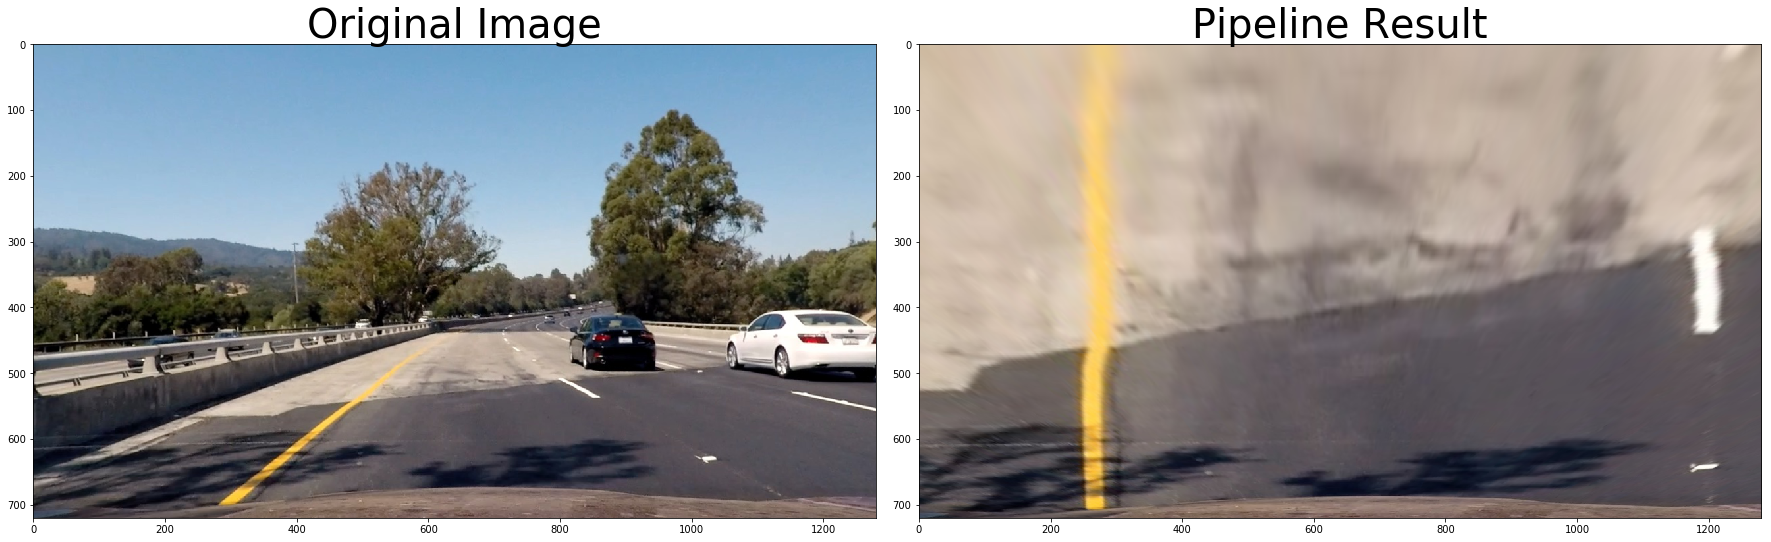

In [116]:
#Perspective Transform
src, dst = get_perspective_src_dst(undistorted)     #programmatically choose four source, destination points
warped, M, Minv = warp_image(undistorted, src, dst)     #apply perspective transform

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

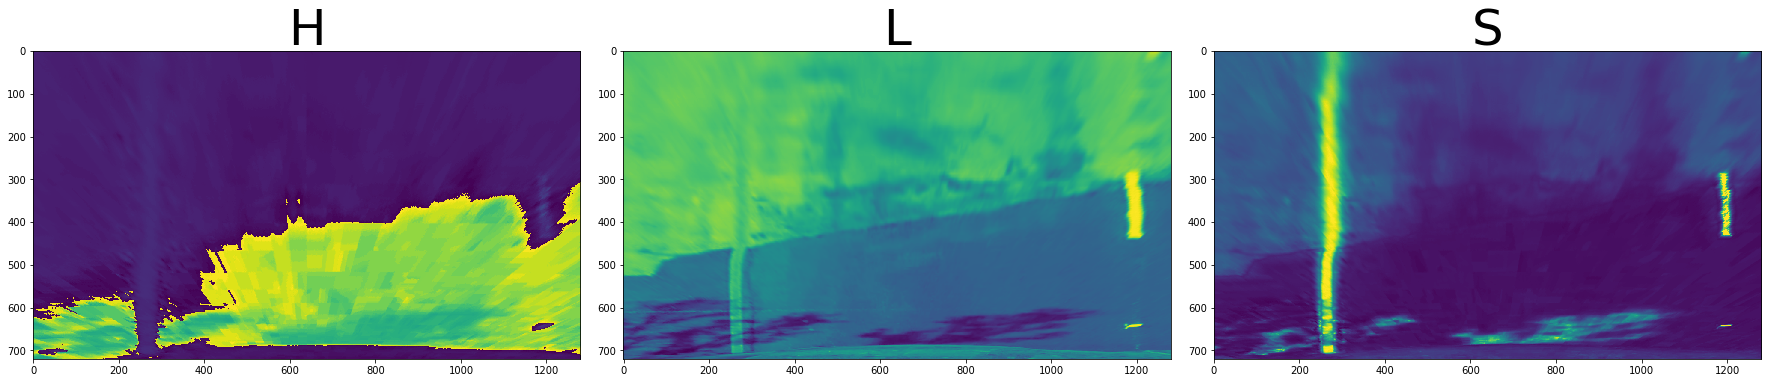

In [117]:
#ColorSpace

hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS).astype(np.float)

H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(H)
ax1.set_title('H', fontsize=50)
ax2.imshow(L)
ax2.set_title('L', fontsize=50)
ax3.imshow(S)
ax3.set_title('S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

(720, 1280)


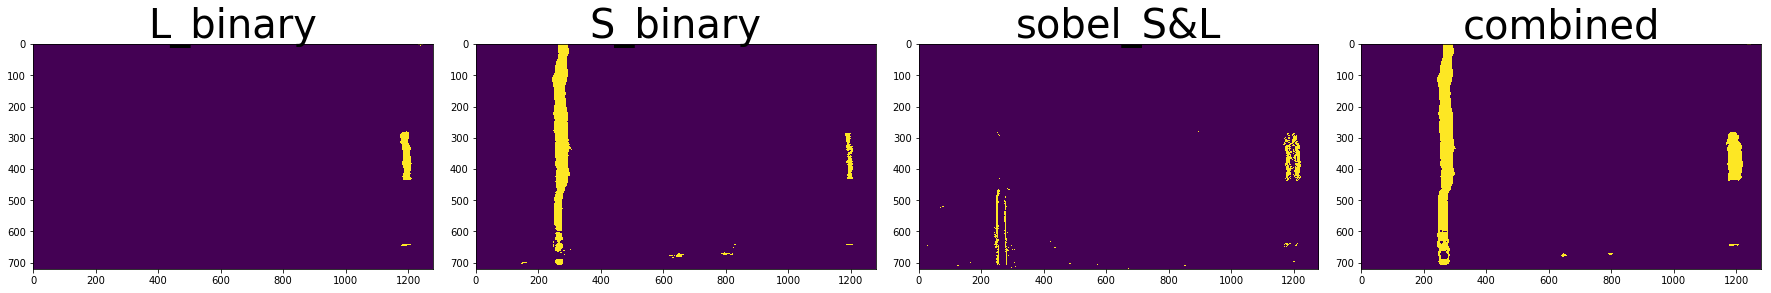

In [118]:
#Color and Gradient Threshold

s_thresh=(170, 255)
l_thresh=(225, 255)
sx_thresh=(50, 125)

l_binary, sxbinary, s_binary, combined_binary = Gradient_Threshold(L, S)

# Plot the result
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()

ax1.imshow(l_binary)
ax1.set_title('L_binary', fontsize=40)

ax2.imshow(s_binary)
ax2.set_title('S_binary', fontsize=40)

ax3.imshow(sxbinary)
ax3.set_title('sobel_S&L', fontsize=40)

ax4.imshow(combined_binary)
ax4.set_title('combined', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

print(combined_binary.shape)

mask_lane.shape
(720, 1280)


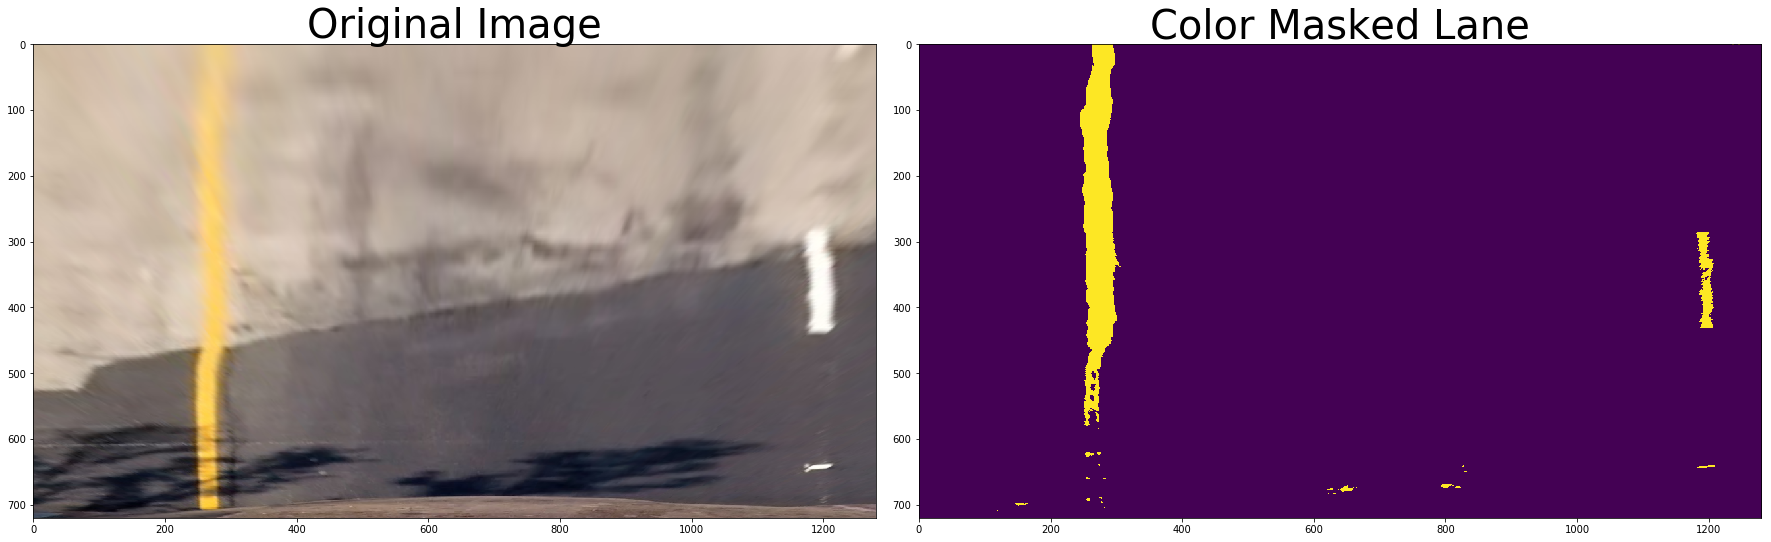

In [119]:
mask_lane = color_scheme(warped)

print("mask_lane.shape")
print(mask_lane.shape)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(mask_lane)
ax2.set_title('Color Masked Lane', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

combined_mask_lane.shape
(720, 1280)


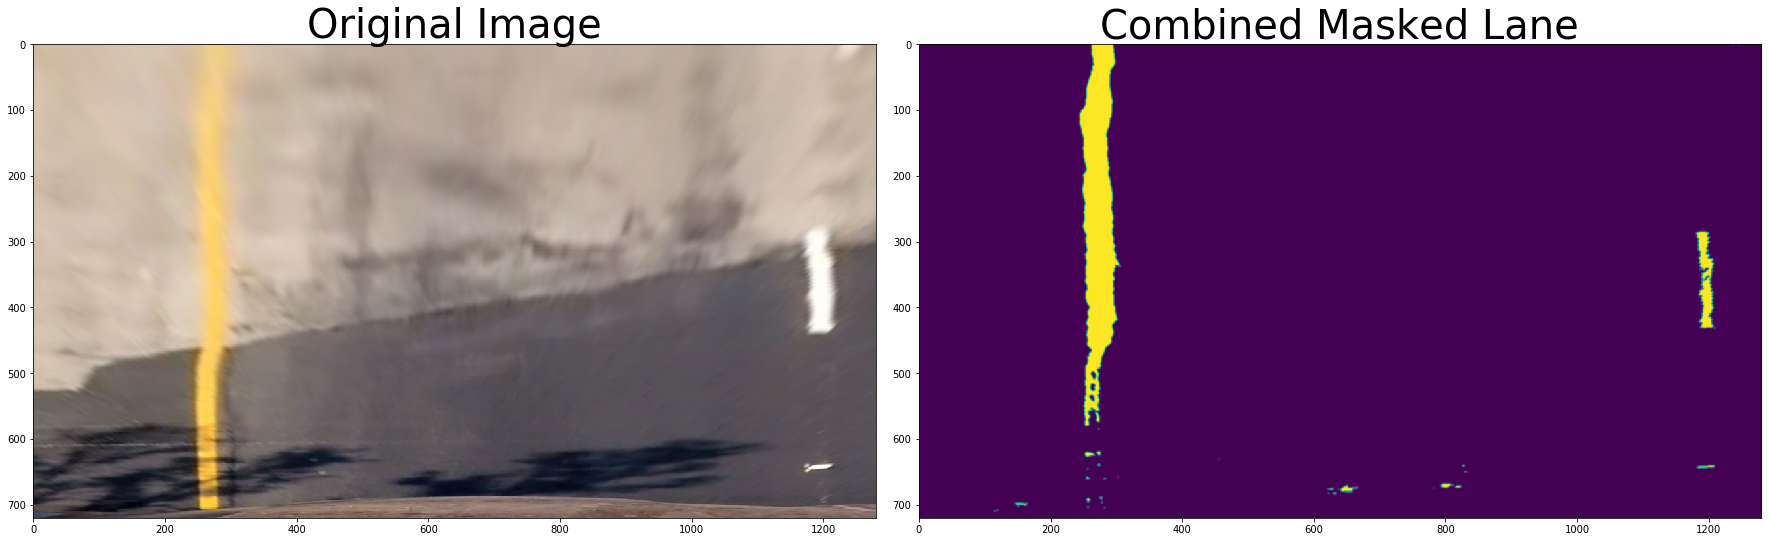

In [120]:
combined_mask_lane = cv2.bitwise_or(combined_binary, mask_lane)
combined_mask_lane = gaussian_blur(combined_mask_lane, kernel_size = 5)

print("combined_mask_lane.shape")
print(combined_mask_lane.shape)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(combined_mask_lane)
ax2.set_title('Combined Masked Lane', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Lane line detection using histogram...

In [180]:
def draw_pw_lines(img,pts,color):
    # draw lines
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(img, (x1, y1), (x2, y2),color,50)

def detect_first_lane(binary_warped):
    # input a warped binary image called "binary_warped"
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    out_img_final = out_img
    
    return(out_img, out_img_final, left_fit, right_fit)

In [181]:
def consecutive_lines(binary_warped, left_fit, right_fit):

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    out_img_final = out_img
    
    return(out_img, out_img_final, left_fit, right_fit)

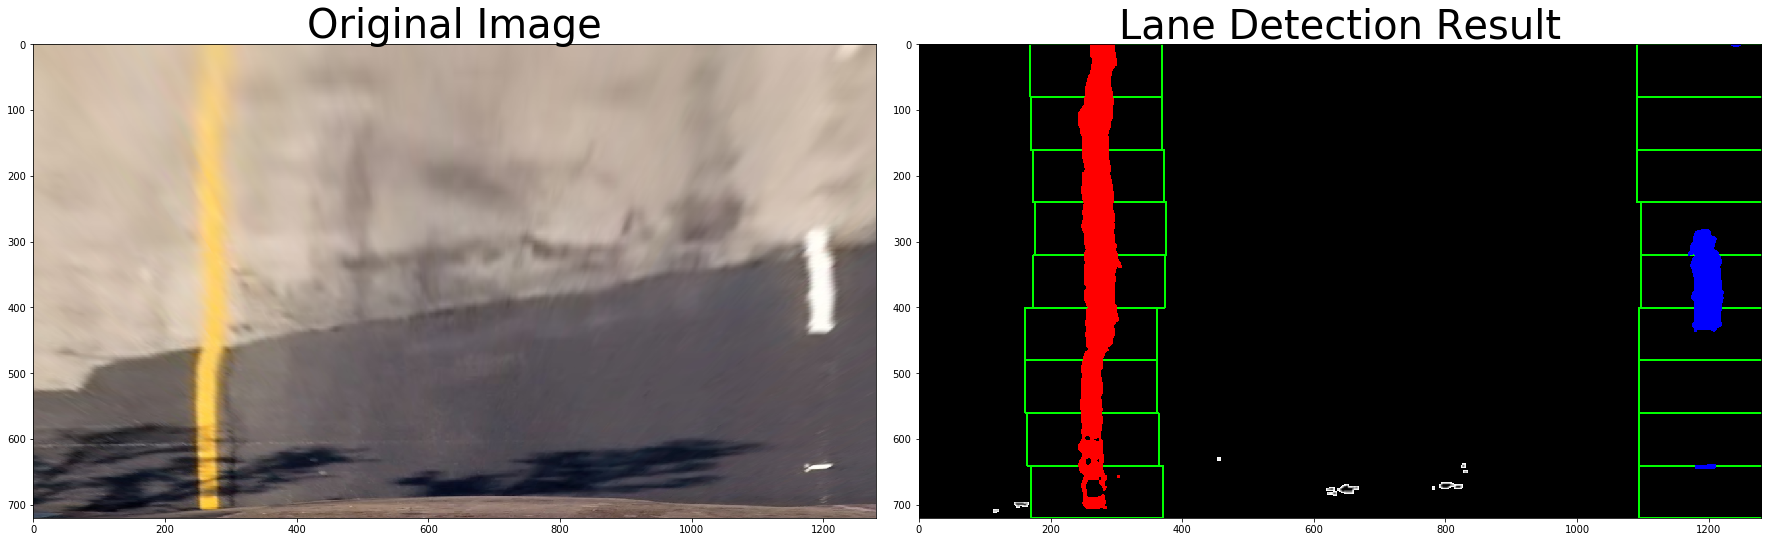

In [182]:
#Lane finding
out_img, out_img_final, left_fit, right_fit = detect_first_lane(combined_mask_lane)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(out_img_final)
ax2.set_title('Lane Detection Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

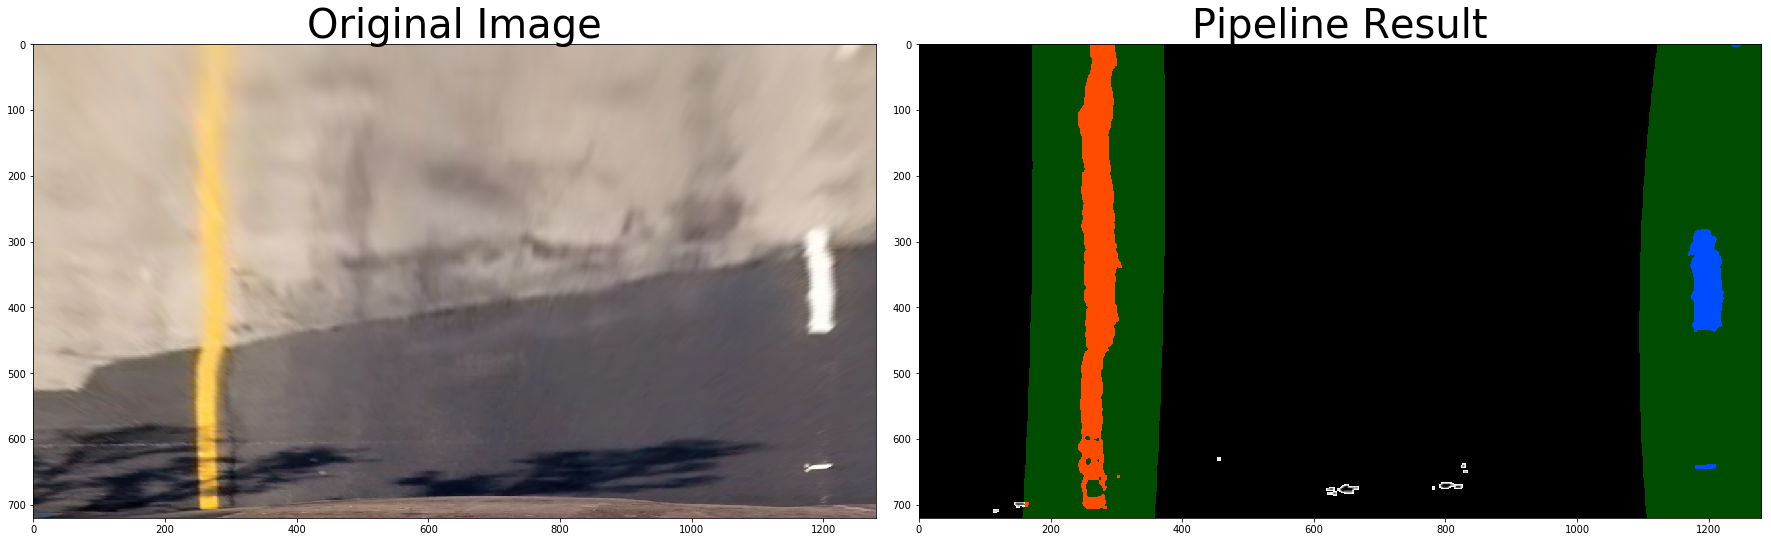

In [163]:
#Lane finding with region of interest
out_img, out_img_final, left_fit, right_fit = consecutive_lines(combined_mask_lane, left_fit, right_fit)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(out_img)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

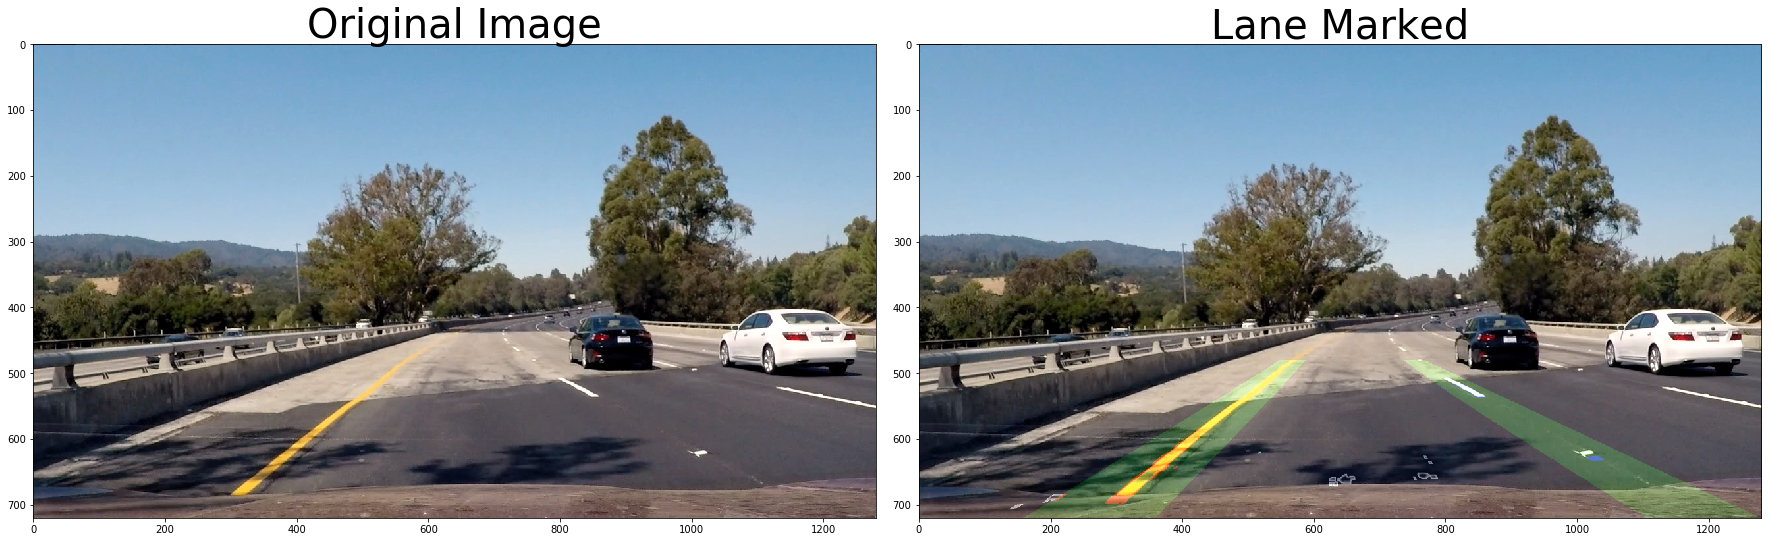

In [164]:
#Go back to perspective view
newarp = cv2.warpPerspective(out_img, Minv, (image.shape[1], image.shape[0])) 

#Add background image
result = cv2.addWeighted(image, 1, newarp, 0.5, 0)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Lane Marked', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [165]:
def pipeline(img):
    global flag, left_fit, right_fit
    
    #Undistort camera, and move to top view
    undistored = cal_undistort(img, objpoints, imgpoints)
    src, dst = get_perspective_src_dst(undistorted)
    warped, M, Minv = warp_image(undistorted, src, dst)
    
    #apply combination of sobel, color and gradient threshold
    hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS).astype(np.float)
    #H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    s_thresh=(170, 255)
    l_thresh=(225, 255)
    sx_thresh=(40, 125)
    
    l_binary, sxbinary, s_binary, combined_binary1 = Gradient_Threshold(L, S)
    combined_binary2 = color_scheme(warped)
    
    combined_mask_lane = cv2.bitwise_or(combined_binary1, combined_binary2) 
    combined_mask_lane = gaussian_blur(combined_mask_lane, kernel_size = 15)
    
    #detect and draw lane lines
    
    if flag == 0:
        detected, left_fit, right_fit = detect_first_lane(combined_mask_lane)
        flag = 1
    else:
        detected, left_fit, right_fit = consecutive_lines(combined_mask_lane, left_fit, right_fit)

    #Go back to perspective view
    newarp = cv2.warpPerspective(detected, Minv, (image.shape[1], image.shape[0])) 

    #Add background image
    result = cv2.addWeighted(img, 1, newarp, 0.5, 0)
    
    return result

In [159]:
#Try Pipeline

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Marked', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

## Now we will measure the curvature of the road...

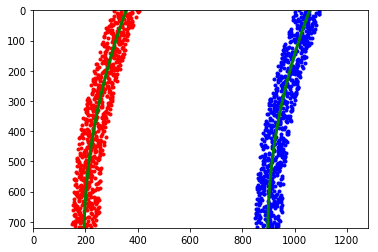

In [120]:
#Measure curvature

# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [121]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

1813.82872563 1678.42726488


In [122]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

595.21333507 m 551.241443764 m


In [123]:
project_output = 'videos/project_video_result.mp4'
clip1 = VideoFileClip('videos/project_video.mp4');
clear_global()
project_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video videos/project_video_result.mp4
[MoviePy] Writing video videos/project_video_result.mp4


100%|█████████▉| 1260/1261 [26:57<00:01,  1.28s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/project_video_result.mp4 

CPU times: user 31min 10s, sys: 3.5 s, total: 31min 13s
Wall time: 26min 58s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [ ]:
# Final plot generation:
    # Generate empty image
    warp_zero = np.zeros_like(combined_mask_lane).astype(np.uint8)
    out_img_final = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_fitx]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_fitx])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(out_img_final, np.int_([pts]), (0,255, 255))

    col_L = (255,255,0)
    col_R = (255,255,255)    

    draw_pw_lines(out_img_final,np.int_(pts_left),col_L)
    draw_pw_lines(out_img_final,np.int_(pts_right),col_R)